# Red Giant Mode fitting

Start with 1 RG star chosen at random.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [24]:
ID = 2018392 # Use ID to choose star
# import data
output = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
star = output.loc[(output['ID'] == ID)]
star

,ID,Numax,Numax_err
907,2018392,32.434535,0.080052


In [29]:
#import output data
modes = pd.read_csv('RGdata/modes_'+str(ID)+'.csv', delim_whitespace=False, header=0, usecols=['f0', 'f0_err'])
modes = modes.sort_values(by=['f0'])
modes = modes.set_index(np.arange(0,len(modes),1))
modes['dnu'] = (modes['f0'].diff(2).shift(-1))/2
dnu_avg = np.mean(modes['dnu'])
n_min = int(modes.f0.min() / dnu_avg)
n_obs = np.arange(n_min, n_min+len(modes.f0), 1)
modes.insert(loc=0, column='n', value=n_obs)
modes

,n,f0,f0_err,dnu
0,6,22.964693,0.061731,NaN
1,7,26.508362,0.026583,3.577379
2,8,30.119451,0.011954,3.712942
3,9,33.934247,0.015399,3.780021
4,10,37.679493,0.022630,3.806206
5,11,41.546658,0.015664,3.895485
6,12,45.470462,0.079150,NaN


To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [86]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

In [117]:
n = modes.n
numax_obs = star.iloc[0]['Numax']
epsilon = 1.02
nmax = numax_obs/dnu_avg - epsilon
k = 0.03
A = 1.8
w = 2
tau = 1.9
phi = 0
f = model(n, dnu_avg, nmax, epsilon, k, A, w, tau, phi)

7.619057640028943


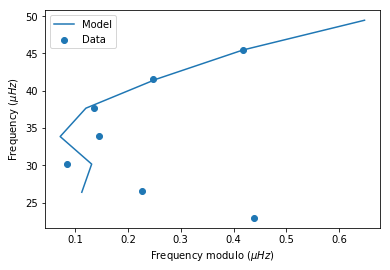

In [116]:
plt.scatter(modes.f0 % dnu_avg, modes.f0, label = 'Data') 
plt.plot(f % dnu_avg, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

In [118]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {   
    real dnu;
    real epsilon;
    real<lower = 0> nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0> w;
    real<lower = -pi(), upper = pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(1.0, 0.50);
    epsilon ~ uniform(-1, 2);
    nmax ~ normal(7, 2);
    k ~ lognormal(log(0.03), 0.02);
    A ~ lognormal(log(1.2), 0.4);
    w ~ normal(1.5, 0.6);
    tau ~ normal(2.0, 0.6);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b8cf1c541d76fa64bfaa8526e103a0af NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpwm2oradc/stanfit4anon_model_b8cf1c541d76fa64bfaa8526e103a0af_8248169320313840688.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [119]:
data = {'N': len(modes.f0), 'freq': modes.f0, 'freq_err': modes.f0_err, 
        'dnu_guess': dnu_avg, 'n': modes.n}
#start = {'dnu': 2.00, 'epsilon': 0.03, 'nmax': nmax, 'k': 0.05, 'A': 0.8, 'w': 0.8, 'phi': -0.9*np.pi, 'tau': 1}
nchains=4
fit = sm.sampling(data=data, iter=5000, chains=nchains)# init=[start for n in range(nchains)])

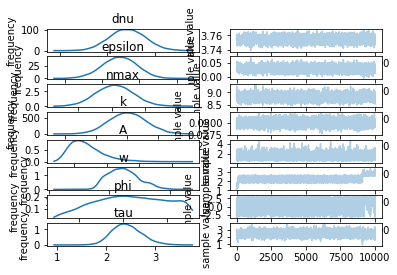

In [120]:
fit.plot()
plt.show()

In [121]:
print(fit)

Inference for Stan model: anon_model_b8cf1c541d76fa64bfaa8526e103a0af.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.75  6.5e-5 3.8e-3   3.75   3.75   3.75   3.76   3.76   3325    1.0
epsilon   0.03  1.7e-4 9.2e-3   0.01   0.02   0.03   0.04   0.05   3063    1.0
nmax      8.82  2.2e-3   0.11    8.6   8.74   8.82   8.89   9.04   2708    1.0
k         0.03  5.6e-6 6.0e-4   0.03   0.03   0.03   0.03   0.03  11352    1.0
A         1.38  7.9e-3   0.51   0.65   1.01   1.29   1.65   2.66   4266    1.0
w         2.24    0.06   0.26   1.82   2.05   2.22    2.4   2.78     21   1.18
phi       0.34    0.21   1.61  -2.69   -0.9   0.34   1.67    3.0     61   1.06
tau       2.42  4.7e-3    0.3   1.89   2.21    2.4   2.62   3.07   4223    1.0
lp__      -0.5    0.29   2.38  -6.09  -1.92  -0.11   1.28   2.99     67   1.06

Samples were drawn 

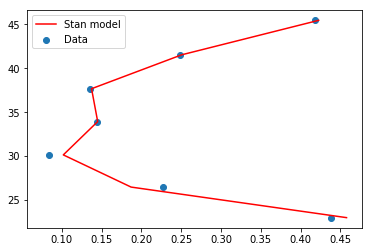

In [122]:
stanfit = model(modes.n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(), fit['A'].mean(), fit['w'].mean(), fit['tau'].mean(), fit['phi'].mean())

plt.subplots()
plt.scatter(modes.f0 % dnu_avg, modes.f0, label = 'Data')
plt.plot(stanfit % fit['dnu'].mean(), stanfit, label = 'Stan model', color = 'r')
plt.legend()

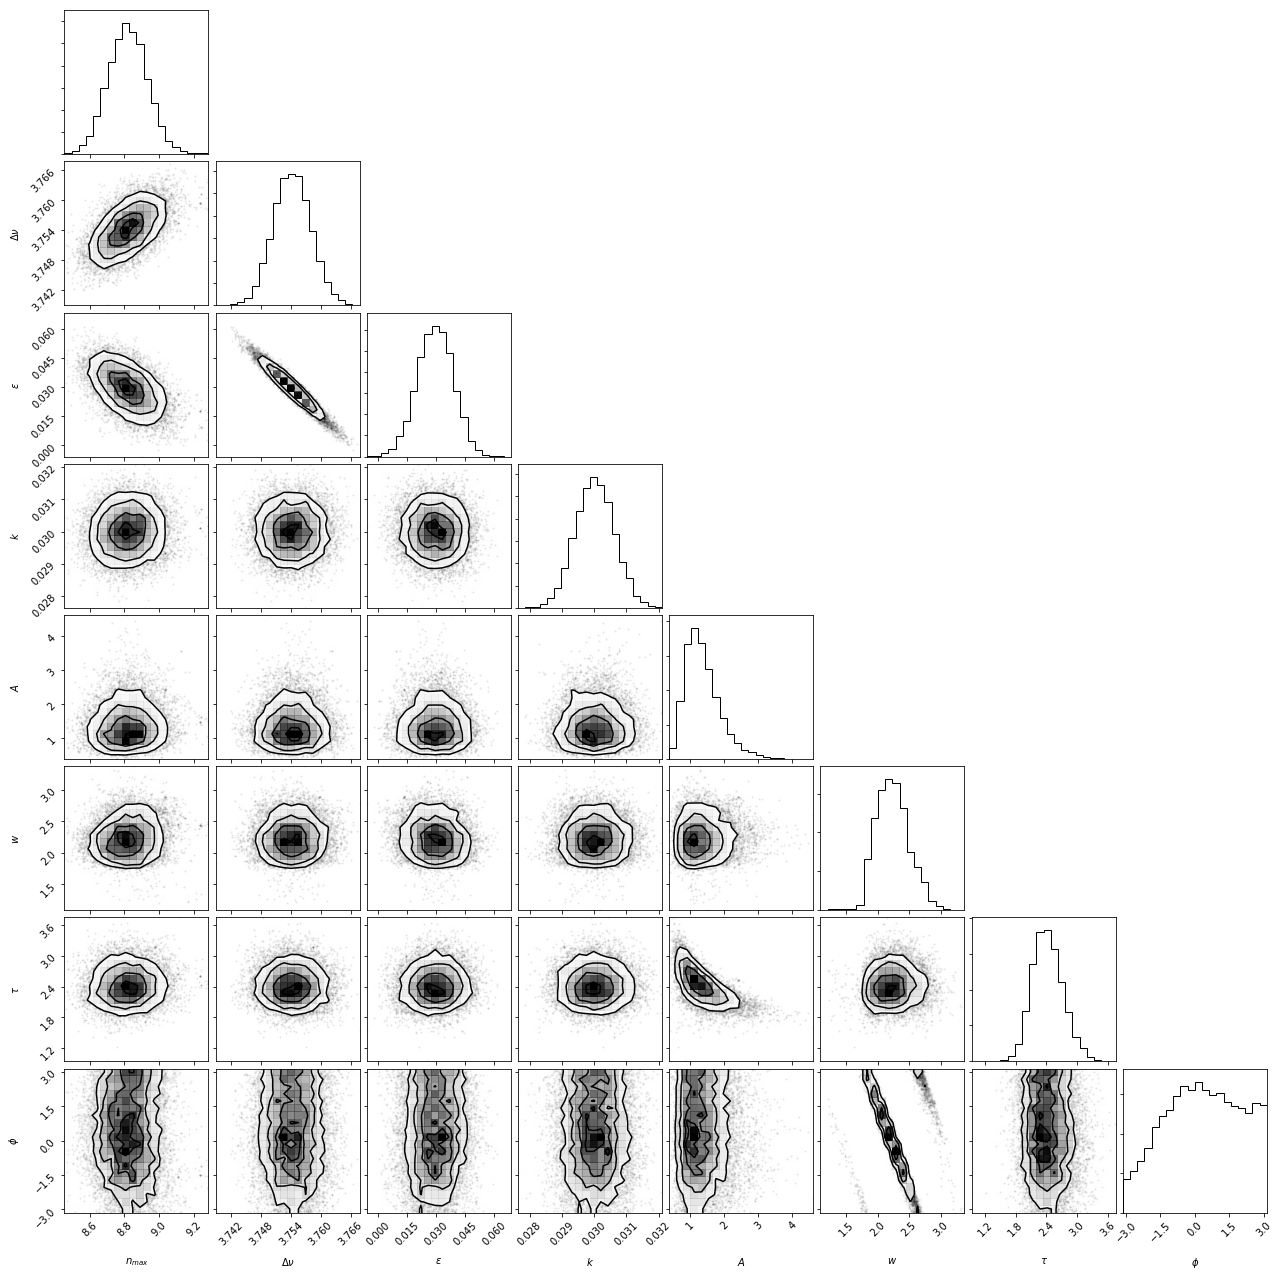

In [123]:
import corner
data = np.vstack([fit['nmax'], fit['dnu'], fit['epsilon'], fit['k'], fit['A'], fit['w'], fit['tau'], fit['phi'],]).T
corner.corner(data, labels=[r'$n_{max}$', r'$\Delta\nu$', r'$\epsilon$', r'$k$', r'$A$', r'$w$', r'$\tau$', r'$\phi$'])
plt.show()